<a href="https://colab.research.google.com/github/MUMADE-TADM/s1_python-gercevas/blob/main/Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yahoo finance](https://finance.yahoo.com/)

In [ ]:
!pip install -U yfinance pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 9.0 MB/s 
     |████████████████████████████████| 62 kB 855 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


# Datos

Valor de cierre del IBEX

In [ ]:
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

In [ ]:
yf.pdr_override() # <== that's all it takes :-)
data = pdr.get_data_yahoo("^IBEX", start="2020-01-01", end="2020-10-30")

[*********************100%***********************]  1 of 1 completed


## [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)

El 97% de los valores de un activo se encuentran entre un máximo de $+1.96 \times  \sigma(20\ valores\ anteriores)$ y $-1.96 \times \sigma(20\ valores\  anteriores)$ centrados en la media de los 20 valores anteriores.

rolling: ventana de 20 valores

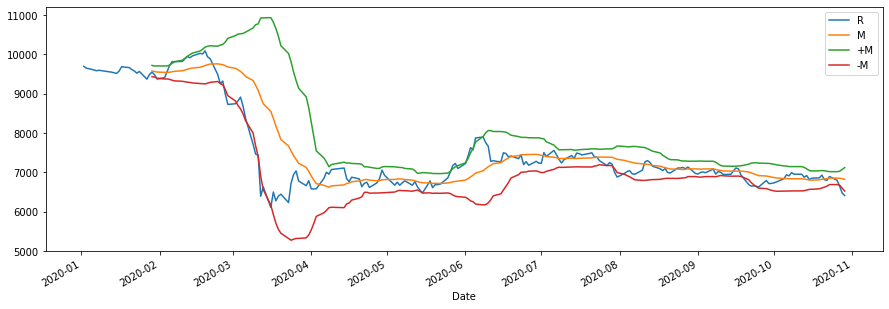

In [ ]:
d=pd.DataFrame()
d['R']=data['Close']
d['M']=data['Close'].rolling(20).mean()
d['+M']=d['M']+data['Close'].rolling(20).std()*1.96
d['-M']=d['M']-data['Close'].rolling(20).std()*1.96
d.plot(figsize=(15,5))

## Transformación de los datos para un problema de regresión / clasificación
- Datos originales $[c_0,\ldots,c_T]$
- Datos transformados:$[[c_0,\ldots,c_{19}],c_{20}],\ldots,[[c_{T-20},\ldots,c_{T-1}],c_T]$.

In [ ]:
def windowData(s,window_input=1,window_output=1,step=1):
  X=[]
  Y=[]
  #Datos necesarios
  dn=window_input+window_output
  #Calcular cuantos pasos completos podemos realizar
  #sin contar el último bloque [input,output]
  ld=int((len(s)-dn)/step)*step
  for i in range(len(s)-ld-1,len(s)-dn,step):
    X.append(s[i:i+window_input])
    Y.append(s[i+window_input:i+dn])
  return X,Y

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Escalanos los datos
dScale = MinMaxScaler()
ldatos=d['R'].values #ldatos.shape=(len(d['R']),)
ldatos=ldatos.reshape((len(d['R']),1)) #ldatos.shape=(len(d['R']),1)
dScale.fit(ldatos)
ldatos=dScale.transform(ldatos).reshape((len(ldatos),))

#Contruimos los conjunto de datos X e Y
X,Y=windowData(ldatos,window_input=20,window_output=1,step=1)
X=np.array(X)
Y=np.array(Y)

#partmos los conjuntos en entranamiento y test
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,shuffle=False, random_state=42)

# PERCEPTRON

## Librerías necesarias 
- [Keras](https://keras.io/)
- [Tensorflow](https://www.tensorflow.org/)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras import metrics

## Definir la Red

Definimos nuestro perceptron con las siguientes capas (**layers**)
- Modelo secuencial [Sequential](https://keras.io/api/models/sequential/)
- Capa de entrada: [Input](https://keras.io/api/layers/core_layers/input/)
- Capa Densa: [Dense](https://keras.io/api/layers/core_layers/dense/) 

secuencial, va a ser una salida de redes neuronales. 
Una capa de 20, otra de 30 y otra de 30. Terminamos, con una capa de 1. Porque normalizamos los valores de entrada entre 0 y 1.

In [ ]:
perceptron=Sequential()
perceptron.add(Input(20))
perceptron.add(Dense(30,activation='relu'))
perceptron.add(Dense(30,activation='relu'))
perceptron.add(Dense(1, activation='sigmoid'))
perceptron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                630       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,591
Trainable params: 1,591
Non-trainable params: 0
_________________________________________________________________


Me esta diciendo que hay tres capas. Cuando le añado la capa, tengo oportunidad de ponerle un nombre. Para: número de parámetros que hay.

## Compilar la red
Definido el **perceptrón** lo tendremos que compilar indicando:
- Que optimizador utilizar.
- Que función de error (pérdida o **loss**).
- Que métricas observar cuando lo entrenemos.

Función [**compile**](https://keras.io/api/models/model_training_apis/#compile-method)

In [ ]:
# compilamos el modelo
perceptron.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        metrics.MeanSquaredError(name='my_mse'),
        metrics.AUC(name='my_auc'),
    ]
)

## Aprender los parámetros

Realizamos el **aprendizaje** indicando:
- Los conjuntos de datos a utilizar **X** e **Y**
- Que proporción de los datos utilizaremos para validar el modelo
- El tamaño del conjunto **batch**
- El número de **épocas** a realizar

Método [**fit**](https://keras.io/api/models/model_training_apis/#fit-method)

La función fit es la función de aprendizaje. Vamos a predecir perceptron.
Datos de entrenamieno: X e Y



In [ ]:
history=perceptron.fit(X,Y,validation_split=0.33, batch_size=10,epochs=300,verbose=0)

In [ ]:
history.history.keys()

dict_keys(['loss', 'my_mse', 'my_auc', 'val_loss', 'val_my_mse', 'val_my_auc'])

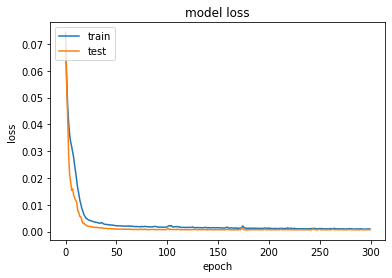

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Que diferencia hay entre ver los valores de test y unos valores aprendidos.

Test muy bajo y aprendizaje muy buenos -> ¿qué significa? No generaliza los datos. Si los datos de test son muy malos con los datos de aprenzdizaje, por lo cual es incapaza de generalizar -> esto es overcity. Clava los datos de aprendizaje pero generaliza poco. 

## Utilizar la red
Utilizar el perceptron aprendido con el método [**predict**](https://keras.io/api/models/model_training_apis/#predict-method)

In [ ]:
Y0=perceptron.predict(X_train)
Y1=perceptron.predict(X_test)

2/2 [==============================] - 0s 5ms/step


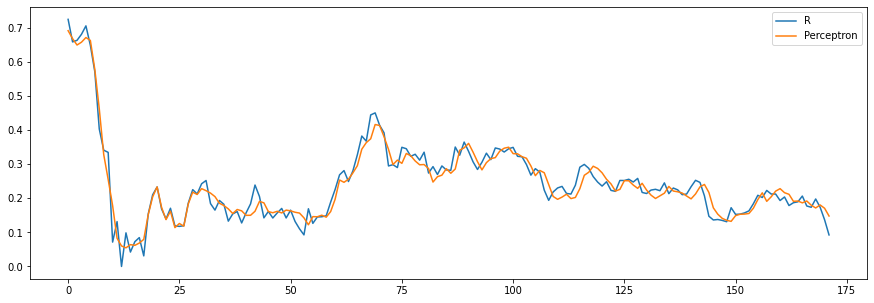

In [ ]:
r=pd.DataFrame(np.vstack((Y_train,Y_test)),columns=['R'])
r['Perceptron']=pd.DataFrame(np.vstack((Y0,Y1)))
r.plot(figsize=(15,5))

## Salvar y Cargar Redes
- Salvar mediante el método [**save**](https://keras.io/api/models/model_saving_apis/#save-method).
- Recuperar un modelo con el método [**load_model**](keras.models.load_model).

Los ficheros H5 -> son ficheros jerarquicos. Almacenar tensores de formar jeráquica.

In [ ]:
perceptron.save('perceptron.h5')
otro_perceptron=keras.models.load_model('perceptron.h5')